In [6]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

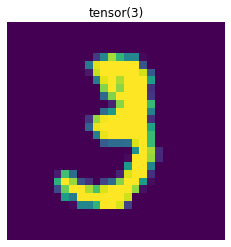

In [7]:
from tensorflow.keras.datasets import mnist


(features_train, targets_train), (features_test, targets_test) = mnist.load_data()

# Convert to float32.

features_train, features_test = np.array(features_train, np.float32), np.array(features_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28).
num_features = 784

features_train, features_test = features_train.reshape([-1, num_features]), features_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1].

features_train, features_test = features_train / 255., features_test / 255

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. 
#Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(featuresTrain[10].reshape(28,28))
plt.axis("off")
plt.title(str(targetsTrain[10]))
plt.savefig('graph.png')
plt.show()

In [8]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        ## DESIGN LAYERS :
        # SEQUENCE: CONV1,ACTIVATION1,POOLING1,  CONV2,ACTIVATION2,POOLING2, LINEAR(FC)

        self.conv1 = nn.Conv2d(
            in_channels=1,              
            out_channels=16,            
            kernel_size=5,              
            stride=1,                   
            padding=2
        )
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        #Fully connected layer, output 10 classes
        self.fc1 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        # COMBINE LAYERS
        ## 1) CONV1
        out = self.conv1(x)
        ## 2) ACTIVATION1
        out = self.relu1(out)
        ## 3) POOLING1
        out = self.pool1(out)
        ## 4) CONV2
        out = self.conv2(out)
        ## 5) ACTIVATION2
        out = self.relu2(out)
        ## 6) POOLING2
        out = self.pool2(out)
        ## 7) flatten
        out = out.view(out.size(0), -1)
        ## 8) LINEAR(FC)
        out = self.fc1(out)
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [9]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.09637695550918579  Accuracy: 97.05000305175781 %
Iteration: 1000  Loss: 0.07205243408679962  Accuracy: 98.06999969482422 %
Iteration: 1500  Loss: 0.0532524436712265  Accuracy: 98.33000183105469 %
Iteration: 2000  Loss: 0.02071383222937584  Accuracy: 98.51000213623047 %


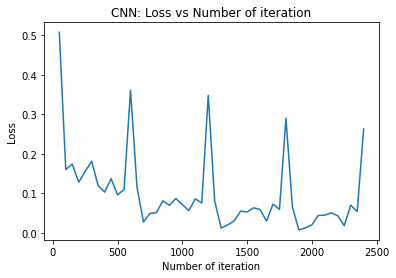

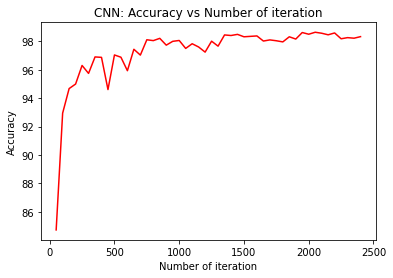

In [10]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()